#Processing and analysis of hand gesture recognition data
##Pipeline for preprocessing, filtering and machine learning evaluation


---


##Code used in "*Improved Vapor Phase Polymerization of Pyrrole on Textiles for Capacitive Strain Sensing and Machine Learning-Assisted Hand Gesture Recognition*"


---

The following code takes a single .txt file that contains 4 columns of sensor values (capacitive or resistive) and one column for the gesture category label. The sensor values come from one sensor on measuring the flexion of each of the following fingers: thumb, index, middlefinger, and ring finger.

The rows in the file are divided into sets. One set is about 1200 - 1400 rows from the same category of gesture. There are 12 gestures, measured 5 times each, and therefore 60 different sets.

After reading the .txt file, the data is put into a dataframe, with each set in a different array. The data is then filtered with a low-pass filter and the beginning and end parts of each set is removed to only keep 1000 rows from each measurement. The data is simultaenously sorted and shuffled (intra-category).

The data was then divided into training and testing sets and used to test various machine learning algorithms.

#Import libraries

In [1]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Read dataset and create the dataframe

In [2]:
path = '/content/drive/MyDrive/GestureFiles'

csv_files = glob.glob(os.path.join(path, "*.txt"))

# Uncomment and comment the correct ones depending on which one you want to test
# Capacitive or Resistive
#file_path = os.path.join(path, "resistiveData.txt") #RESISTIVE
file_path = os.path.join(path, "capacitiveData.txt") #CAPACITIVE

# Read the entire file into a DataFrame
data = pd.read_csv(file_path, sep=',')
data['Category'] = data['Category'].astype(int)

# Empty DataFrame to hold the unfiltered data
bufferData = []

# Temporary list to hold the current set (of rows / measurement)
bufferRows = []

# Variable to track the current category we are adding rows to
currentCategory = None

for index, row in data.iterrows():
    if currentCategory is None:
        currentCategory = row['Category']

    if row['Category'] != currentCategory:
        # Convert the list of rows to a DataFrame and append to bufferData
        bufferData.append(pd.DataFrame(bufferRows))

        bufferRows = []
        currentCategory = row['Category']

    # Add new row to the bufferRows for the current category (current measurement)
    bufferRows.append(row)

# Append any remaining rows to bufferData (for the last measurement in the file)
if bufferRows:
    bufferData.append(pd.DataFrame(bufferRows))
bufferData


[       sensor1   sensor2   sensor3   sensor4  Category
 0     34.65195  39.65530  40.04486  41.49826       1.0
 1     34.58099  39.64203  40.06500  41.51611       1.0
 2     34.68170  39.59763  40.04120  41.53717       1.0
 3     34.68765  39.64066  40.02930  41.50375       1.0
 4     34.59747  39.64111  40.08240  41.52893       1.0
 ...        ...       ...       ...       ...       ...
 1346  34.78790  39.76929  40.15793  41.31607       1.0
 1347  34.78424  39.76151  40.16937  41.32660       1.0
 1348  34.75220  39.76105  40.18906  41.32202       1.0
 1349  34.75632  39.75876  40.16479  41.74225       1.0
 1350  34.75357  39.72305  40.16800  41.89743       1.0
 
 [1351 rows x 5 columns],
        sensor1   sensor2   sensor3   sensor4  Category
 1351  35.38940  42.92740  42.10846  44.19174       2.0
 1352  35.42328  43.04825  42.22427  44.16428       2.0
 1353  35.39398  43.20847  42.32681  44.14139       2.0
 1354  35.41687  43.05878  42.28058  44.13269       2.0
 1355  35.53955  42.

# Filtering (1Hz Low-Pass)

In [3]:
# Cut-off at 0.05 of the Nyquist frequency (20 Hz, sampling rate is about 40 Hz)
# Cut-off at 1 Hz
sos = signal.butter(3, 0.05, 'low', output='sos')
filteredData = bufferData
cName = ['sensor1', 'sensor2', 'sensor3', 'sensor4']
for i in range(len(bufferData)):
  for j in range(len(cName)): #number of columns
    filteredData[i][cName[j]] = signal.sosfilt(sos, bufferData[i][cName[j]])

Visualization of data

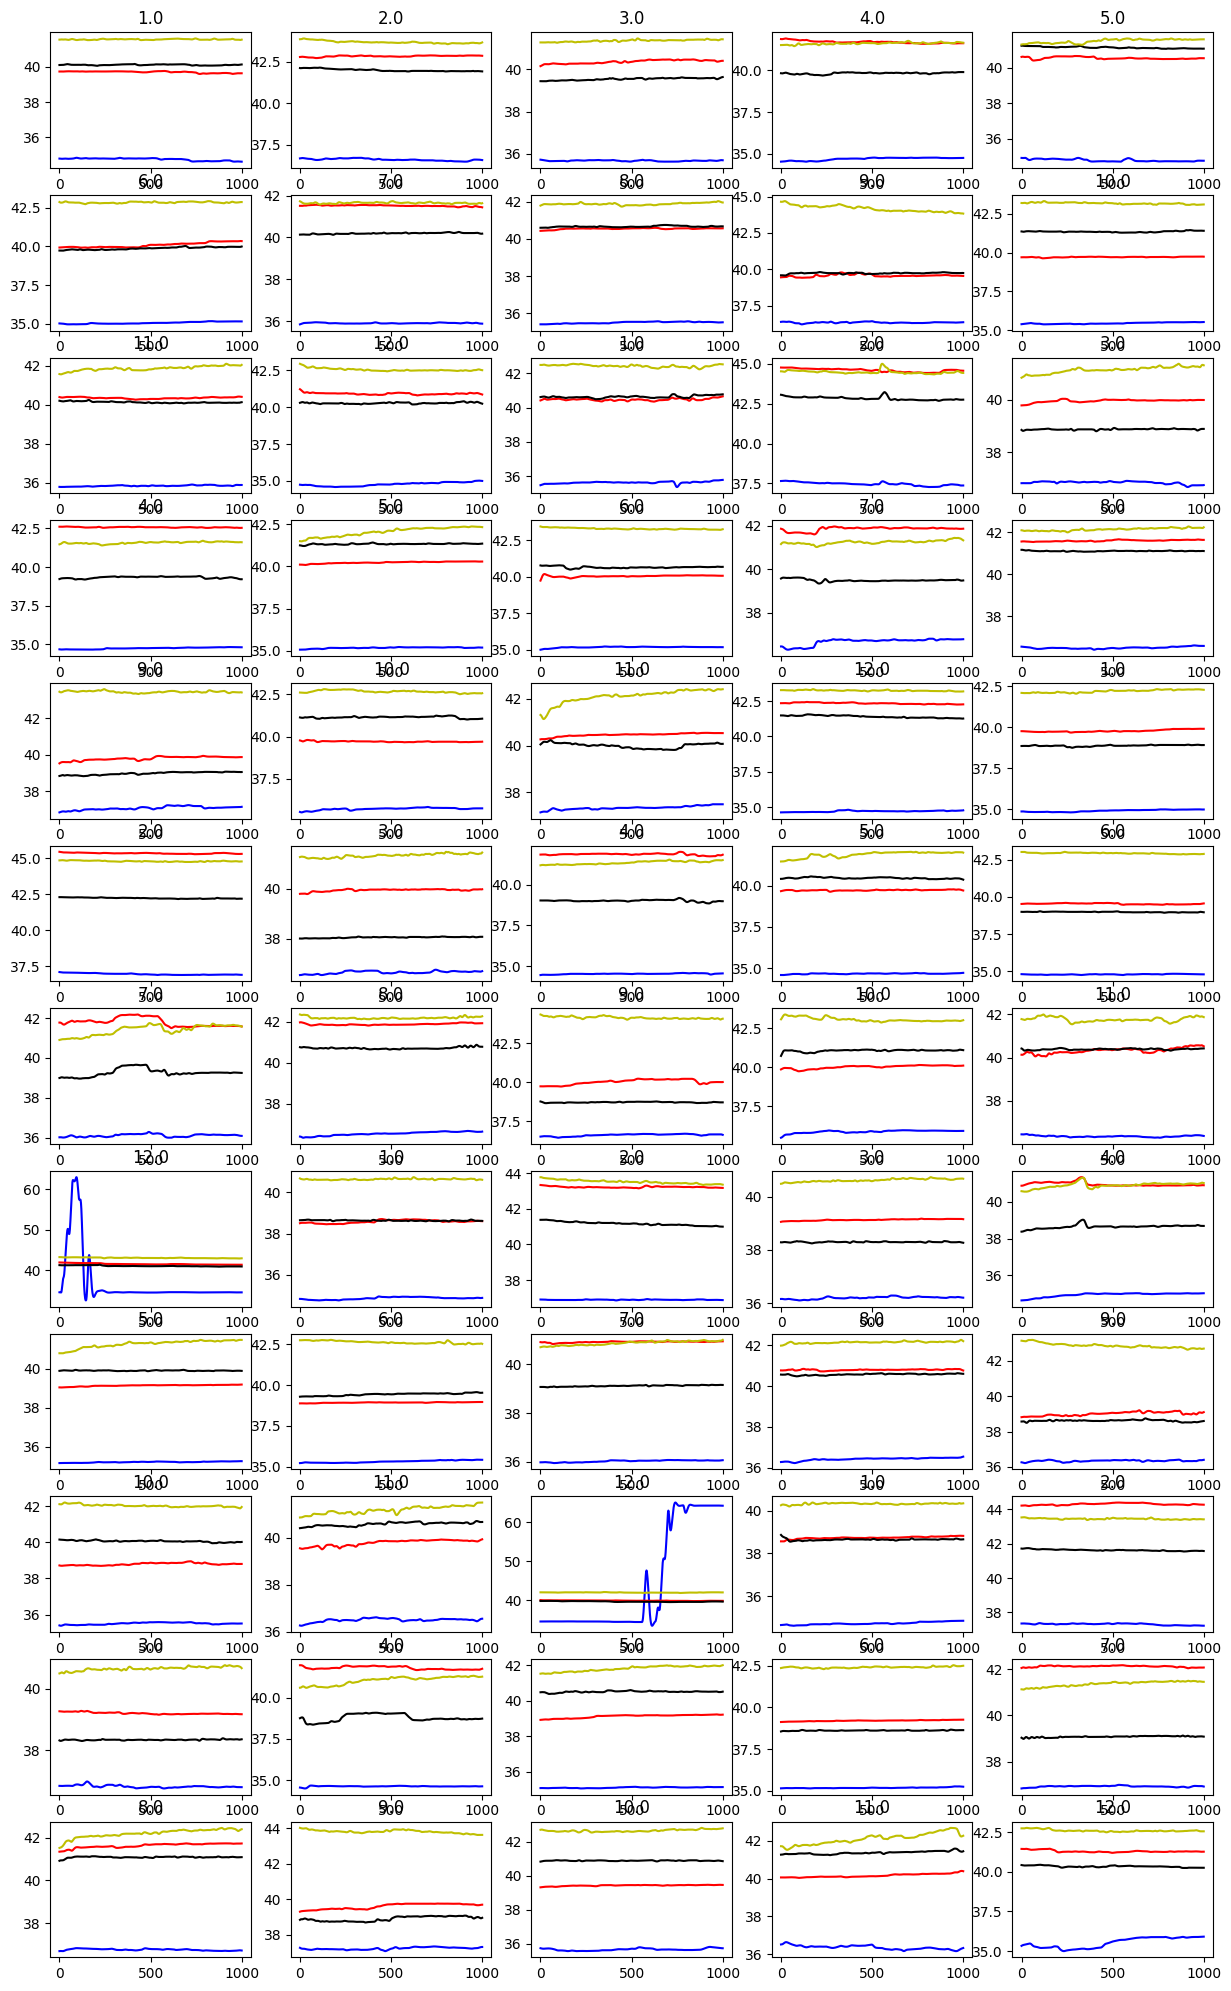

In [ ]:
plt.figure(figsize=(15, 25))
for i in range(0, 60):
  plt.subplot(12, 5, (i+1))
  plt.plot(filteredData[i]["sensor1"][150:1150].reset_index(drop=True), 'b')
  plt.plot(filteredData[i]["sensor2"][150:1150].reset_index(drop=True), 'r')
  plt.plot(filteredData[i]["sensor3"][150:1150].reset_index(drop=True), 'k')
  plt.plot(filteredData[i]["sensor4"][150:1150].reset_index(drop=True), 'y')
  plt.title(filteredData[i]["Category"].iloc[0])
  #plt.ylim([34, 45]) # FOR CAPACITIVE
  #plt.ylim([300, 900]) # FOR RESISTIVE

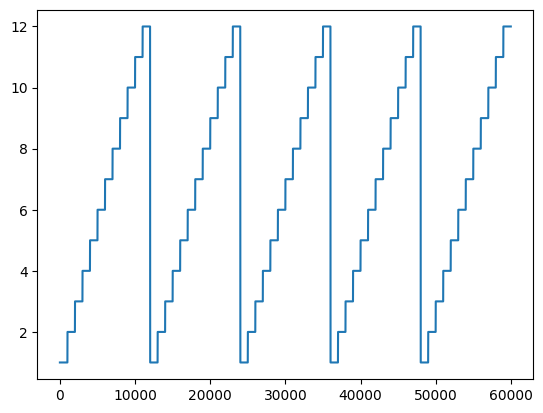

In [4]:
# We only take 1000 samples from each measurement
# which represent approximately 30s of data
finalData = filteredData[0][150:1150]
for i in range(1, len(filteredData)):
  finalData = pd.concat([finalData, filteredData[i][150:1150]], ignore_index=True)
plt.plot(finalData["Category"])

Sort data (and shuffle intra-category) to have categories together

In [6]:
sort = np.argsort(finalData["Category"])
# This is where the data is shuffled at the
# same time as it is sorted into categories
sortedData = np.array(finalData)[sort]
sortedCategory = np.array(finalData["Category"])[sort]

#Training

Divide data into training and testing sets (4:1)

So there is 4 **of each category** in training, and 1 in testing

In [7]:
X_tr = []
X_ts = []
y_tr = []
y_ts = []
X_tr, X_ts, y_tr, y_ts = train_test_split(np.delete(sortedData, -1, -1)[:5000],sortedCategory[:5000],
                                   test_size=0.2, shuffle = False)
for i in range(1, 12):
  X_train, X_test, y_train, y_test = train_test_split(np.delete(sortedData, -1, -1)[i*5000:(i+1)*5000],sortedCategory[i*5000:(i+1)*5000],
                                   test_size=0.2, shuffle = False)
  X_tr = np.concatenate((X_tr, X_train), axis=0)
  X_ts = np.concatenate((X_ts, X_test), axis=0)
  y_tr = np.concatenate((y_tr, y_train), axis=0)
  y_ts = np.concatenate((y_ts, y_test), axis=0)

# Training

Dummy classifier

In [ ]:
clf = DummyClassifier(strategy="uniform")
clf = clf.fit(X_tr, y_tr)
y_predict = clf.predict(X_ts)
accuracy_score(y_ts, y_predict)

0.08325

Decision tree

In [ ]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_tr.tolist(), y_tr)
y_predict = clf.predict(X_ts.tolist())
accuracy_score(y_ts, y_predict)

0.8214166666666667

Random forest

In [9]:
clf = RandomForestClassifier()
clf = clf.fit(X_tr, y_tr)
y_pred = clf.predict(X_ts)
accuracy_score(y_ts, y_pred)

0.8545

Logistic regression

In [ ]:
clf = make_pipeline(StandardScaler(), LogisticRegression(random_state=1))
clf = clf.fit(X_tr, y_tr)
y_pred = clf.predict(X_ts)
accuracy_score(y_ts, y_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8313333333333334

LDA

In [ ]:
clf = make_pipeline(StandardScaler(), LDA())
clf.fit(X_tr, y_tr)
y_predict = clf.predict(X_ts)
accuracy_score(y_ts, y_predict)

0.62375

Linear SVM

In [ ]:
clf = make_pipeline(StandardScaler(), LinearSVC(dual=False, random_state=1, tol=1e-5))
clf.fit(X_tr, y_tr)
y_predict = clf.predict(X_ts)
accuracy_score(y_ts, y_predict)

0.6953333333333334

RBF SVM

In [15]:
svm_clf = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1, random_state=1))
svm_clf.fit(X_tr, y_tr)
y_predict = svm_clf.predict(X_ts)
accuracy_score(y_ts, y_predict)

0.7908333333333334

Nearest neighbors

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(X_tr, y_tr)
y_predict = neigh.predict(X_ts)
accuracy_score(y_ts, y_predict)

1.0

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_tr, y_tr)
y_predict = neigh.predict(X_ts)
accuracy_score(y_ts, y_predict)

1.0

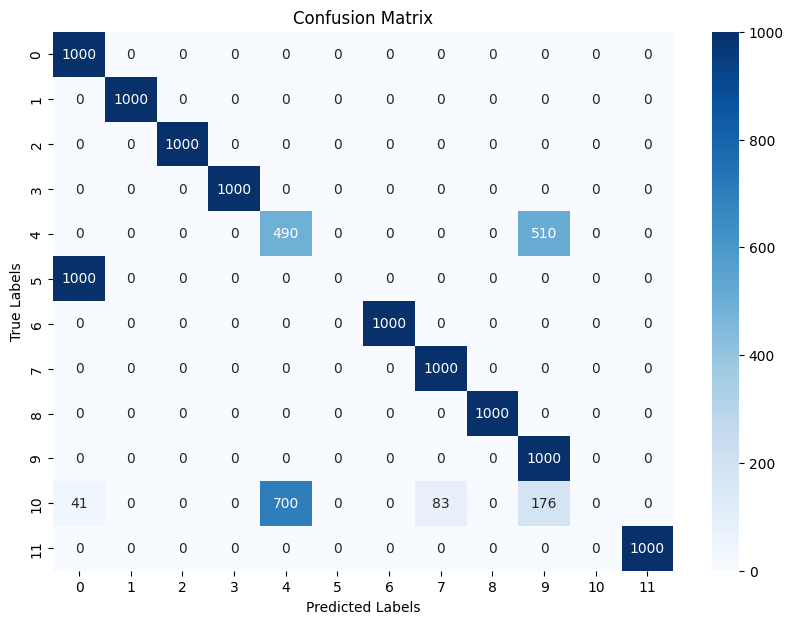

In [16]:
cm = confusion_matrix(y_ts, y_predict)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Fine tuning with validation

In [ ]:
nns = np.arange(1, 51)
param_grid = dict(n_neighbors=nns)

neigh = KNeighborsClassifier()

grid = GridSearchCV(neigh, param_grid, cv=5, scoring='accuracy', return_train_score=True,verbose=3)

# fitting the model for grid search
grid_search=grid.fit(X_tr, y_tr)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END .n_neighbors=1;, score=(train=1.000, test=1.000) total time=   1.1s
[CV 2/5] END .n_neighbors=1;, score=(train=1.000, test=0.997) total time=   1.6s
[CV 3/5] END .n_neighbors=1;, score=(train=1.000, test=1.000) total time=   1.1s
[CV 4/5] END .n_neighbors=1;, score=(train=1.000, test=1.000) total time=   1.0s
[CV 5/5] END .n_neighbors=1;, score=(train=1.000, test=0.995) total time=   0.6s
[CV 1/5] END .n_neighbors=2;, score=(train=1.000, test=1.000) total time=   0.5s
[CV 2/5] END .n_neighbors=2;, score=(train=1.000, test=0.997) total time=   0.6s
[CV 3/5] END .n_neighbors=2;, score=(train=1.000, test=1.000) total time=   0.5s
[CV 4/5] END .n_neighbors=2;, score=(train=1.000, test=1.000) total time=   0.7s
[CV 5/5] END .n_neighbors=2;, score=(train=1.000, test=0.995) total time=   0.5s
[CV 1/5] END .n_neighbors=3;, score=(train=1.000, test=1.000) total time=   0.5s
[CV 2/5] END .n_neighbors=3;, score=(train=1.00

In [ ]:
grid_search.cv_results_['mean_test_score']

array([0.998375  , 0.998375  , 0.99475   , 0.99477083, 0.99475   ,
       0.99477083, 0.99477083, 0.99477083, 0.99475   , 0.99477083,
       0.99475   , 0.99477083, 0.99470833, 0.99472917, 0.99470833,
       0.99464583, 0.99464583, 0.99454167, 0.99454167, 0.99447917,
       0.99445833, 0.994375  , 0.99435417, 0.99433333, 0.9943125 ,
       0.9943125 , 0.99427083, 0.99429167, 0.99429167, 0.99429167,
       0.99429167, 0.9943125 , 0.99429167, 0.99435417, 0.99435417,
       0.9943125 , 0.9943125 , 0.9943125 , 0.9943125 , 0.99433333,
       0.9943125 , 0.9943125 , 0.99433333, 0.9944375 , 0.9944375 ,
       0.9945625 , 0.9945625 , 0.99458333, 0.99458333, 0.99470833])

Fine tuning with validation

Text(0.5, 1.0, 'Parameter search')

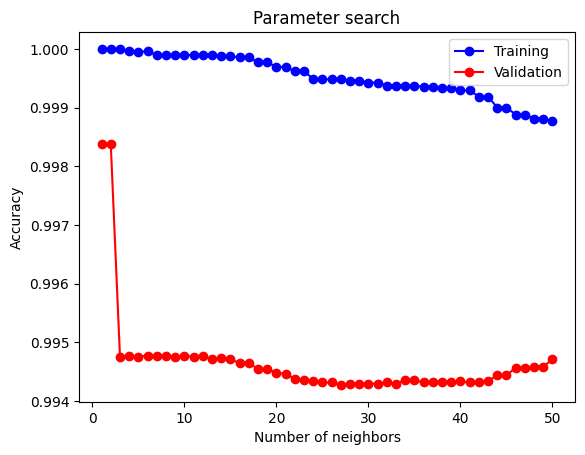

In [ ]:
plt.plot(nns, grid_search.cv_results_['mean_train_score'], 'b-o', label="Training")
plt.plot(nns, grid_search.cv_results_['mean_test_score'], 'r-o', label="Validation")
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy")
#plt.ylim(0.8, 1.005)
plt.legend()
plt.title("Parameter search")